<a href="https://colab.research.google.com/github/ibkvictor/classifier_CIFAR10/blob/main/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

getting the data and normalizing

In [22]:
#define the transforms to occur on the images - converion to tensor and normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #normalize(mean, std) for each channel

#download and transfrom data
train_data = torchvision.datasets.CIFAR10(root= './data', train = True, transform = transform, download = True)

#creating data loader for train_data
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = 4, shuffle = True, num_workers = 2) #shuffle: True for train, num_workers represent num of cores used for process.

#download and transfrom data
test_data = torchvision.datasets.CIFAR10(root= './data', train = False, transform = transform, download = True)

#creating data loader for test_data
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 4, shuffle = False, num_workers = 2) #shuffle: False for test, num_workers represent num of cores used for process.

#defining out classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


checking out our loaded data

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def imshow(img):
  #unnormalizing
  img = img / 2 + 0.5

  #covert image to numpy array
  img = img.numpy()
  plt.imshow(img.transpose(1, 2, 0)) #transpose so img can be heigh, width, channel and not channel, width, height
  
  #displays image
  plt.show()

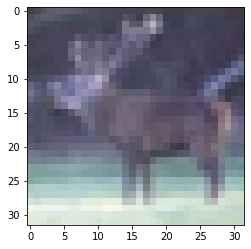

deer


In [23]:
#randomly generating data
rand_train = iter(train_loader)
rand_train_data = rand_train.next()

#unpacking values to images and labels
images, labels = rand_train_data

#display image
imshow(images[0])

#print class label
print(classes[labels[0].item()])

creating a neural network

In [25]:
import torch.nn as nn
import torch.nn.functional as F

In [92]:
class Net(nn.Module):
  def __init__(self):
    """
    initializing network parameters
    """
    #inheritance of all components of nn.Module initialized parameters
    super(Net, self).__init__()

    #creating layers
    
    #first convnet layer
    self.conv1 = nn.Conv2d(3, 6, 5) #parsed are the input channels, output channels and filter size

    #second convnet layer
    self.conv2 = nn.Conv2d(6, 16, 5) #parsed are the input channels, output channels and filter size

    #maxpooling layer
    self.maxpool = nn.MaxPool2d(2) #the kernel size for maxpool

    #fully connected layer 1
    self.fc1 = nn.Linear(5 * 5 * 16 , 120) #parsed are the input nodes and output nodes

    #fully connected layer 2
    self.fc2 = nn.Linear(120, 56)

    #output layer 3
    self.fc3 = nn.Linear(56, 10)

  def forward(self, x):
    """
    feed forward operation of network from input
    output: network output
    """
    X = F.relu(self.maxpool(self.conv1(x)))

    X = F.relu(self.maxpool(self.conv2(X)))

    X = X.view(-1, self.flat_nodes(X))
    
    X = F.relu(self.fc1(X))

    X = F.relu(self.fc2(X))

    out = self.fc3(X)
    return out

  def flat_nodes(self, x):
    flat_sizes = list(x.size()[1:])

    num_nodes = 1
    for i in flat_sizes:
      num_nodes *= i

    return num_nodes


In [93]:
#initilialize network
net = Net()

In [43]:
print(net.parameters)

<bound method Module.parameters of Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=56, bias=True)
  (fc3): Linear(in_features=56, out_features=10, bias=True)
)>


define loss and optimizer

In [94]:
#importing optimizer
import torch.optim as optimizer

#defining loss function
loss_fn = torch.nn.CrossEntropyLoss()

#setting optimizer - learning rate and momentum
optm = optimizer.SGD(net.parameters(), lr = 0.001, momentum = 0.9) #net.parameters(), learning_rate, momentum

Begin training

In [95]:
for epoch in range(2):
  monitor_loss = 0.0
  for i, data in enumerate(train_loader):
    
    #unpacking values
    image, label = data

    #set network and optimizer gradients to zero
    optm.zero_grad()

    #(working across batch, so no need for individual calculation)
    #feed forward
    output = net(image)

    #calculate loss
    loss = loss_fn(output, label)

    #compute gradients
    loss.backward()

    #optimizer performs a step of gradient descent using already initialised learning rate
    optm.step()


    #printing out loss
    monitor_loss += loss.item()
    if i % 2000 == 1999: #because the networks runs from 0 - .. hence to print out the 0, 1999, 3999, loss (i.e after every 2000 step)
      print('[%d, %5d] loss: %f'%(epoch + 1, i + 1, monitor_loss / 2000))
      
      #reset monitor loss after every full pass of training set
      monitor_loss = 0.0



[1,  2000] loss: 2.224431
[1,  4000] loss: 1.886197
[1,  6000] loss: 1.677084
[1,  8000] loss: 1.598515
[1, 10000] loss: 1.538594
[1, 12000] loss: 1.468669
[2,  2000] loss: 1.413332
[2,  4000] loss: 1.368615
[2,  6000] loss: 1.350648
[2,  8000] loss: 1.331506
[2, 10000] loss: 1.308549
[2, 12000] loss: 1.296194


saving model

In [96]:
path = './model.pt'
torch.save(net.state_dict(), path)

testing model

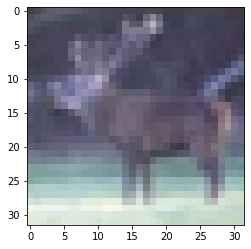

deer


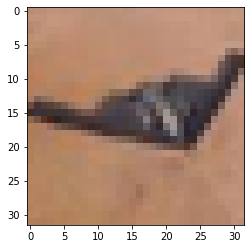

airplane


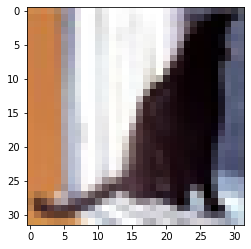

dog


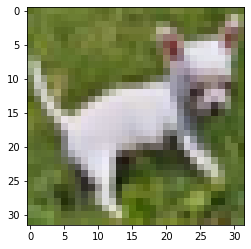

horse


In [97]:
rand_test = iter(test_loader)
rand_test_data = rand_test.next()

#unpacking values
images, labels = rand_train_data

#parsing to model
predictions = net(images)
for i in range(4):
  _, prediction = predictions.max(1)
  #display image
  imshow(images[i])

  #display label
  print(classes[prediction[i].item()])

Metrics of Accuracy, testing the entire test dataset

In [98]:
total = 0
correct = 0

#iterating through entire set
for images, labels in test_loader:
  outputs = net(images)
  _, predictions = outputs.max(1) #argmax or max function produces indicies and values

  total += labels.size()[0]
  correct += (labels == predictions).sum()

#printing accuracy
print("accuracy: [%.3f]"%(100 * correct / total))



accuracy: [54.080]


metrics of accuracy per item got wrong

In [99]:
correct = [0] * 10
total = [0] * 10

#iterating through entire set
with torch.no_grad():
  for images, labels in test_loader:
    outputs = net(images)
    _, predictions = outputs.max(1) #argmax or max function produces indicies and values

    for i in range(4):
      if prediction[i] == labels[i]:
        correct[prediction[i]] += 1
      total[labels[i]] += 1

#printing accuracy
for r in range(len(classes)):
  print("accuracy of %s: [%.3f]"%(classes[r] ,100 * correct[r] / total[r]))

accuracy of airplane: [26.000]
accuracy of automobile: [0.000]
accuracy of bird: [0.000]
accuracy of cat: [0.000]
accuracy of deer: [24.400]
accuracy of dog: [23.300]
accuracy of frog: [0.000]
accuracy of horse: [25.600]
accuracy of ship: [0.000]
accuracy of truck: [0.000]
